<a href="https://colab.research.google.com/github/DevMed22/Revive_My_Memory/blob/model/models/mci_classification_resnet_FirstSprint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://www.bu.edu/files/2022/07/feat-crop-iStock-1026002288.jpg" width=70%/>


**Alzheimer's disease** is a condition where neurons within the brain stop functioning, lose connection with other neurons and die. It's the most common cause of dementia, a loss of brain function that can adversely impact memory, thinking, language, judgment and behavior. Alzheimer's is irreversible and progressive.

Alzheimer's is evaluated by identifying certain symptoms and ruling out other possible causes of dementia. Your doctor will likely perform a complete medical exam, including neurological, blood and brain imaging exams, such as CT, MRI or PET/CT of the head. There is no cure for Alzheimer's disease. However, your doctor may prescribe medication to slow the disease's progression and manage your symptoms.

**MRI of the head**: Magnetic resonance imaging (MRI) uses a powerful magnetic field, radio frequency pulses and a computer to produce detailed pictures of organs, soft tissues, bone and virtually all other internal body structures. MRI can detect brain abnormalities associated with mild cognitive impairment (MCI) and can be used to predict which patients with MCI may eventually develop Alzheimer's disease. In the early stages of Alzheimer's disease, an MRI scan of the brain may be normal. In later stages, MRI may show a decrease in the size of different areas of the brain (mainly affecting the temporal and parietal lobes).

## In this NoteBook

**In this NoteBook**, a convolutional neural network (CNN)-based Alzheimer MRI images classification algorithm is developed using **ResNet152V2** architecture, to detect **"Alzheimer's disease"**, **"Cognitively normal"**, **"Early mild cognitive impairment"** and **"Late mild cognitive impairment"** in patient's MRI.


# Importing Libraries

In [1]:
!pip install pydicom
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 49.1 MB/s eta 0:00:00


In [3]:
import os
import pydicom
import numpy as np
import pandas as pd
import splitfolders
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import applications
from PIL import Image
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
    
from helper_functions import plot_loss_curves

--2023-02-14 16:05:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-14 16:05:16 (91.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Uploading the Data

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [19]:
! cp kaggle.json ~/.kaggle/

In [20]:
! chmod 600 ~/.kaggle/kaggle.json

In [21]:
!kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset-v2

100% 379M/379M [00:21<00:00, 19.5MB/s]
100% 379M/379M [00:21<00:00, 18.3MB/s]


In [22]:
! unzip /content/augmented-alzheimer-mri-dataset-v2.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/val/NonDemented/31 (10).jpg  
  inflating: data/val/NonDemented/31 (100).jpg  
  inflating: data/val/NonDemented/31 (11).jpg  
  inflating: data/val/NonDemented/31 (12).jpg  
  inflating: data/val/NonDemented/31 (13).jpg  
  inflating: data/val/NonDemented/31 (14).jpg  
  inflating: data/val/NonDemented/31 (15).jpg  
  inflating: data/val/NonDemented/31 (16).jpg  
  inflating: data/val/NonDemented/31 (17).jpg  
  inflating: data/val/NonDemented/31 (18).jpg  
  inflating: data/val/NonDemented/31 (19).jpg  
  inflating: data/val/NonDemented/31 (2).jpg  
  inflating: data/val/NonDemented/31 (20).jpg  
  inflating: data/val/NonDemented/31 (21).jpg  
  inflating: data/val/NonDemented/31 (22).jpg  
  inflating: data/val/NonDemented/31 (23).jpg  
  inflating: data/val/NonDemented/31 (24).jpg  
  inflating: data/val/NonDemented/31 (25).jpg  
  inflating: data/val/NonDemented/31 (26).jpg  
  inflating: data/val/NonDemented/31 

In [23]:
SAMPLE_PER_CATEGORY = 200
SEED = 42
WIDTH = 128
HEIGHT = 128
DEPTH = 3
INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)


# Converting DICOM to jpg

In [13]:
!pip install dicom2jpg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 59.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.2 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.


In [14]:
# import dicom2jpg
# # convert all DICOM files in dicom_dir folder to jpg format
# dicom2jpg.dicom2jpg('/content/drive/MyDrive/ADNI_data/data_model/data/AD_Unziped')

# Creating Train and Validation DataFrame

In [24]:
data_dir='/content/data'
train_dir='/content/data/train'
test_dir='/content/data/val'

In [25]:
CATEGORIES = ["Alzheimer's disease", 'Cognitively normal', 'Early mild cognitive impairment', 'Late mild cognitive impairment']
NUM_CATEGORIES = len(CATEGORIES)
NUM_CATEGORIES

4

In [27]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.shape

Copying files: 11 files [04:21, 23.77s/ files]


(33984, 3)

In [28]:
train = train.sample(frac=1)
X = train.drop(columns = 'category_id')
y = train['category_id']

In [30]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=4)

In [31]:
train = pd.concat([x_train, y_train], axis=1)
validation = pd.concat([x_valid, y_valid], axis=1)

In [32]:
train = train.reset_index()
train = train.drop(columns = 'index')
validation = validation.reset_index()
validation = validation.drop(columns = 'index')
print(train.shape)
print(validation.shape)

(27187, 3)
(6797, 3)


In [33]:
train.head()

file  \
0  train/Cognitively normal/1367764f-3189-4b5b-9b...   
1  train/Alzheimer's disease/c80ffc53-e6e5-46c6-9...   
2  train/Alzheimer's disease/33ab049d-77a7-4b18-a...   
3  train/Early mild cognitive impairment/cf7f5e34...   
4  train/Early mild cognitive impairment/a5ec5476...   

                          category  category_id  
0               Cognitively normal            1  
1              Alzheimer's disease            0  
2              Alzheimer's disease            0  
3  Early mild cognitive impairment            2  
4  Early mild cognitive impairment            2

In [34]:
validation.head()

file  \
0  train/Alzheimer's disease/2ac4b4a1-f6a1-4214-a...   
1  train/Cognitively normal/eef973f8-9d29-4030-81...   
2  train/Late mild cognitive impairment/ef315aa6-...   
3  train/Early mild cognitive impairment/00965011...   
4  train/Cognitively normal/7f54c763-7bac-451a-9e...   

                          category  category_id  
0              Alzheimer's disease            0  
1               Cognitively normal            1  
2   Late mild cognitive impairment            3  
3  Early mild cognitive impairment            2  
4               Cognitively normal            1

# Creating Test DataFrame

In [35]:
test = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(test_dir, category)):
        test.append(['val/{}/{}'.format(category, file), category_id, category])
test = pd.DataFrame(test, columns=['file', 'category_id', 'category'])
test.shape

(6400, 3)

# Demonstrating Example Images

In [36]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

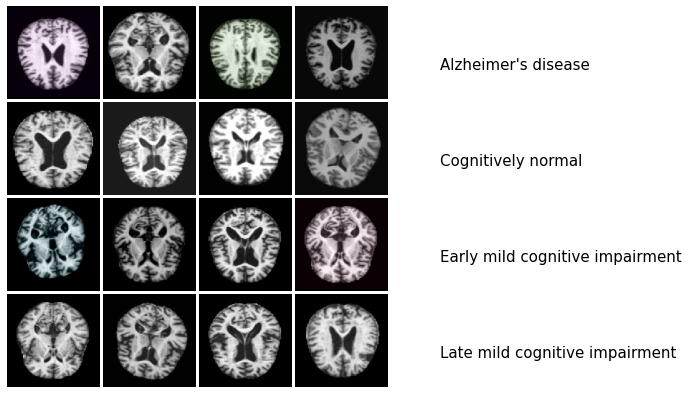

In [80]:
fig = plt.figure(1, figsize=(7, 7))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)

i=0    
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (WIDTH, HEIGHT))
        ax.imshow(img / 255)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(200, 80, filepath.split('/')[1], verticalalignment='center',size=15)
        i+=1
        
plt.show();

# Keras ImageDataGenerator

In [38]:
datagen_train = ImageDataGenerator(rescale=1./255)
train_generator = datagen_train.flow_from_dataframe(dataframe=train,
                                                  directory=data_dir,
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32,
                                                  seed=SEED,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

validation_generator = datagen_train.flow_from_dataframe(dataframe=validation,
                                                  directory=data_dir,
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32,
                                                  seed=SEED,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

Found 27187 validated image filenames belonging to 4 classes.
Found 6797 validated image filenames belonging to 4 classes.


In [39]:
datagen_test = ImageDataGenerator(rescale=1./255)
test_generator = datagen_test.flow_from_dataframe(dataframe=test,
                                                  directory=data_dir,
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32,
                                                  seed=SEED,
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

Found 6400 validated image filenames belonging to 4 classes.


# Early Stopping

In [40]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Creating Model based on ResNet152V2

In [41]:
def create_model():
   
    resnet_model = tf.keras.applications.resnet_v2.ResNet152V2(
        weights='imagenet',
        include_top = False,
        input_shape = (224, 224, 3)
    )
    
    for layers in resnet_model.layers[:100]:
        layers.trainable = False
    for layers in resnet_model.layers[100:]:
        layers.trainable = True

    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    # output layer
    predictions = tf.keras.layers.Dense(4, activation='softmax')(x)

    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    # Compiling the model
    res_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return res_model

In [42]:
res_model = create_model()

234545216/234545216 [==============================] - 11s 0us/step


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.525289 to fit



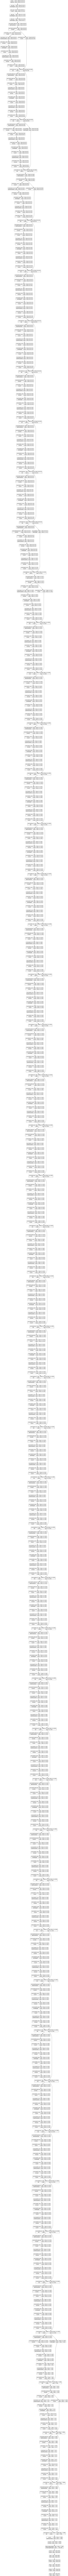

In [43]:
plot_model(res_model, to_file='res_model.png', show_shapes=True)

In [44]:
res_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

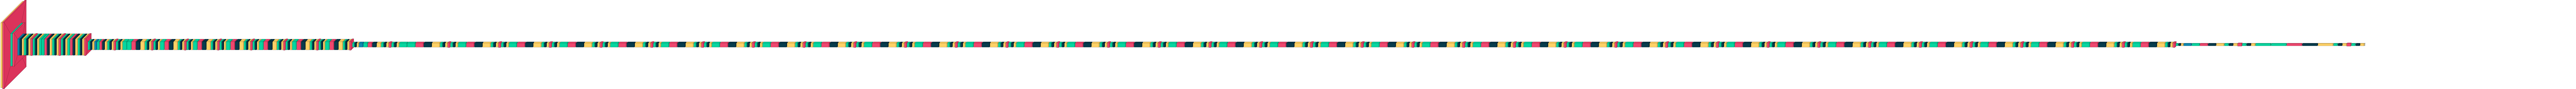

In [45]:
import visualkeras
visualkeras.layered_view(res_model).show() # display using your system viewer
visualkeras.layered_view(res_model, to_file='res_model_viz.png').show() # write and show

visualkeras.layered_view(res_model)

### Training the Model

In [46]:
history = res_model.fit(train_generator,
                    epochs=500, 
                    steps_per_epoch=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping],
                    batch_size=32)

Epoch 1/500
100/100 [==============================] - 137s 465ms/step - loss: 1.1471 - accuracy: 0.4484 - val_loss: 860.7064 - val_accuracy: 0.1891
Epoch 2/500
100/100 [==============================] - 46s 464ms/step - loss: 0.8613 - accuracy: 0.5909 - val_loss: 4.0871 - val_accuracy: 0.5035
Epoch 3/500
100/100 [==============================] - 47s 467ms/step - loss: 0.7757 - accuracy: 0.6420 - val_loss: 3.2736 - val_accuracy: 0.5271
Epoch 4/500
100/100 [==============================] - 46s 461ms/step - loss: 0.7021 - accuracy: 0.6975 - val_loss: 2.4649 - val_accuracy: 0.5538
Epoch 5/500
100/100 [==============================] - 46s 463ms/step - loss: 0.6400 - accuracy: 0.7159 - val_loss: 4.5622 - val_accuracy: 0.5017
Epoch 6/500
100/100 [==============================] - 46s 460ms/step - loss: 0.6237 - accuracy: 0.7312 - val_loss: 2.2357 - val_accuracy: 0.5836
Epoch 7/500
100/100 [==============================] - 43s 435ms/step - loss: 0.5586 - accuracy: 0.7563 - val_loss: 0.709

In [47]:
res_model.save('mci-resnet.h5')

### Plotting the history of model

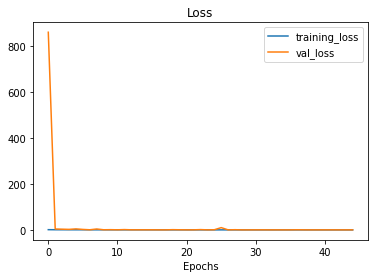

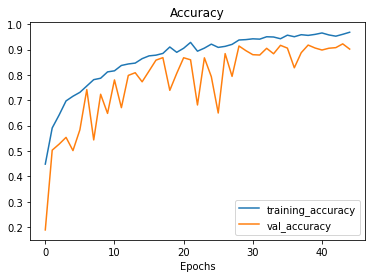

In [48]:
plot_loss_curves(history)

### Evaluation

In [49]:
valid_loss, valid_accuracy = res_model.evaluate(validation_generator)

print(f'\nTrain loss: {valid_loss:.2f}')
print(f'Train Accuracy: {valid_accuracy*100:.2f} %')

213/213 [==============================] - 19s 89ms/step - loss: 0.3596 - accuracy: 0.9017

Train loss: 0.36
Train Accuracy: 90.17 %


In [50]:
loss, accuracy = res_model.evaluate(test_generator)

print(f'\nTest loss: {loss:.2f} ')
print(f'Test Accuracy: {accuracy*100:.2f} %')

200/200 [==============================] - 18s 87ms/step - loss: 0.0656 - accuracy: 0.9753

Test loss: 0.07 
Test Accuracy: 97.53 %


In [88]:
y_predict = res_model.predict(test_generator)
prediction = np.argmax(y_predict,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
prediction = [labels[k] for k in prediction]

y_test = list(test.category)

report = classification_report(y_test, prediction, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('mci-resnet-result', sep='\t', encoding='utf-8')
df

200/200 [==============================] - 17s 84ms/step


precision    recall  f1-score      support
Alzheimer's disease               0.991545  0.942411  0.966354  2240.000000
Cognitively normal                0.975100  0.991250  0.983109  3200.000000
Early mild cognitive impairment   0.984615  1.000000  0.992248    64.000000
Late mild cognitive impairment    0.939140  0.998884  0.968091   896.000000
accuracy                          0.975313  0.975313  0.975313     0.975313
macro avg                         0.972600  0.983136  0.977450  6400.000000
weighted avg                      0.975917  0.975313  0.975233  6400.000000

<Figure size 3600x3600 with 0 Axes>

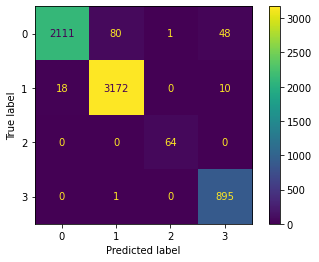

In [87]:
fig=plt.figure(figsize=(50,50))
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_labels = list(test_generator.class_indices.keys())   

confusion_matrix = metrics.confusion_matrix(y_test, prediction,labels=CATEGORIES)  # shape=(12, 12)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=CATEGORIES)
disp.plot(xticks_rotation=45)
fig.show()

# Creating Model based on DenseNet201

In [94]:
def create_model_densenet():
   
    densenet_model = tf.keras.applications.DenseNet201(include_top = False, pooling = 'avg', weights = 'imagenet'
        ,input_shape = (224, 224, 3)
    )
    
    for layers in densenet_model.layers[:100]:
        layers.trainable = False
    for layers in densenet_model.layers[100:]:
        layers.trainable = True

    x = densenet_model.output
    
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    # output layer
    predictions = tf.keras.layers.Dense(4, activation='softmax')(x)

    dense_model = tf.keras.Model(inputs=densenet_model.input, outputs=predictions)

    # Compiling the model
    dense_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return dense_model

In [95]:
dense_model = create_model_densenet()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.471746 to fit



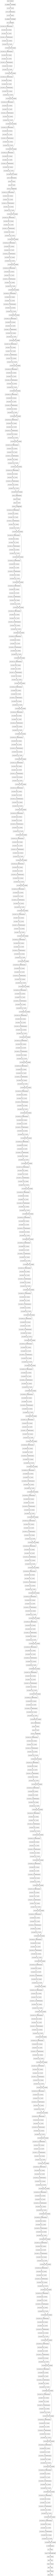

In [97]:
plot_model(dense_model, to_file='dense_model.png')

In [98]:
dense_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [99]:
import visualkeras
visualkeras.layered_view(dense_model).show() # display using your system viewer
visualkeras.layered_view(dense_model, to_file='res_model_viz.png').show() # write and show

visualkeras.layered_view(dense_model)

### Training the Model

In [101]:
history_dense = dense_model.fit(train_generator,
                    epochs=50, 
                    steps_per_epoch=100,
                    validation_data=validation_generator,
                    batch_size=32)

Epoch 1/50
100/100 [==============================] - 32s 318ms/step - loss: 0.2609 - accuracy: 0.8978 - val_loss: 1.8529 - val_accuracy: 0.6626
Epoch 2/50
100/100 [==============================] - 40s 397ms/step - loss: 0.2626 - accuracy: 0.8991 - val_loss: 0.5426 - val_accuracy: 0.8395
Epoch 3/50
100/100 [==============================] - 32s 317ms/step - loss: 0.2517 - accuracy: 0.9112 - val_loss: 0.7784 - val_accuracy: 0.7806
Epoch 4/50
100/100 [==============================] - 39s 389ms/step - loss: 0.2235 - accuracy: 0.9209 - val_loss: 2.3202 - val_accuracy: 0.6663
Epoch 5/50
100/100 [==============================] - 32s 316ms/step - loss: 0.1698 - accuracy: 0.9388 - val_loss: 0.3320 - val_accuracy: 0.8935
Epoch 6/50
100/100 [==============================] - 32s 320ms/step - loss: 0.1575 - accuracy: 0.9444 - val_loss: 0.5346 - val_accuracy: 0.8257
Epoch 7/50
100/100 [==============================] - 32s 319ms/step - loss: 0.1466 - accuracy: 0.9434 - val_loss: 0.3109 - val_ac

In [102]:
dense_model.save('mci-dense.h5')

### Plotting the history of model

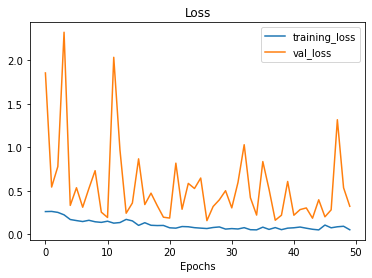

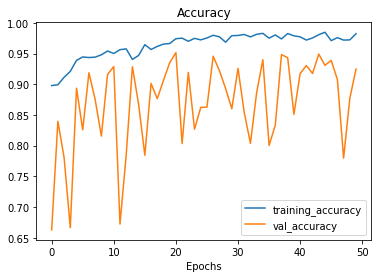

In [103]:
plot_loss_curves(history_dense)

### Evaluation

In [104]:
valid_loss, valid_accuracy = dense_model.evaluate(validation_generator)

print(f'\nTrain loss: {valid_loss:.2f}')
print(f'Train Accuracy: {valid_accuracy*100:.2f} %')

213/213 [==============================] - 15s 70ms/step - loss: 0.3217 - accuracy: 0.9247

Train loss: 0.32
Train Accuracy: 92.47 %


In [105]:
loss, accuracy = dense_model.evaluate(test_generator)

print(f'\nTest loss: {loss:.2f} ')
print(f'Test Accuracy: {accuracy*100:.2f} %')

200/200 [==============================] - 13s 65ms/step - loss: 0.1878 - accuracy: 0.9586

Test loss: 0.19 
Test Accuracy: 95.86 %


In [ ]:
y_predict = dense_model.predict(test_generator)
prediction = np.argmax(y_predict,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
prediction = [labels[k] for k in prediction]

y_test = list(test.category)

report = classification_report(y_test, prediction, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('mci-dense-result', sep='\t', encoding='utf-8')
df

200/200 [==============================] - 17s 84ms/step


precision    recall  f1-score      support
Alzheimer's disease               0.991545  0.942411  0.966354  2240.000000
Cognitively normal                0.975100  0.991250  0.983109  3200.000000
Early mild cognitive impairment   0.984615  1.000000  0.992248    64.000000
Late mild cognitive impairment    0.939140  0.998884  0.968091   896.000000
accuracy                          0.975313  0.975313  0.975313     0.975313
macro avg                         0.972600  0.983136  0.977450  6400.000000
weighted avg                      0.975917  0.975313  0.975233  6400.000000

<Figure size 3600x3600 with 0 Axes>

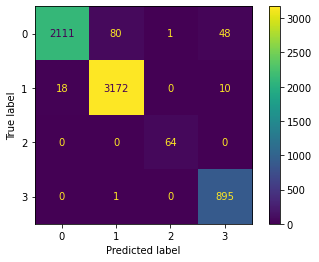

In [110]:
fig=plt.figure(figsize=(50,50))
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_labels = list(test_generator.class_indices.keys())   

confusion_matrix = metrics.confusion_matrix(y_test, prediction)  
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot()
fig.show()